<a href="https://colab.research.google.com/github/JanisJ2/jsc270-a4/blob/main/JSC270_Assignment_4_janis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github link: https://github.com/JanisJ2/jsc270-a4 \
Group member:
- Christoffer Tan (1008740445)
- Janis Joplin (10097515051)


In [142]:
# Import necessary modules
from google.colab import files
import io
import sys
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve

from scipy.cluster.hierarchy import dendrogram, linkage

import seaborn as sns

import nltk
nltk.download('punkt')  # Tokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [143]:
# Read the dataset from GitHub
!wget "https://raw.githubusercontent.com/JanisJ2/jsc270-a4/main/covid-tweets-train.csv"
!wget "https://raw.githubusercontent.com/JanisJ2/jsc270-a4/main/covid-tweets-test.csv"

--2024-03-31 21:36:07--  https://raw.githubusercontent.com/JanisJ2/jsc270-a4/main/covid-tweets-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8991364 (8.6M) [text/plain]
Saving to: ‘covid-tweets-train.csv.2’

covid-tweets-train. 100%[===================>]   8.57M  --.-KB/s    in 0.1s    

2024-03-31 21:36:08 (67.5 MB/s) - ‘covid-tweets-train.csv.2’ saved [8991364/8991364]

--2024-03-31 21:36:08--  https://raw.githubusercontent.com/JanisJ2/jsc270-a4/main/covid-tweets-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [144]:
# Read the train data from CSV file
train_data = pd.read_csv('covid-tweets-train.csv')
train_data.columns = ['Label', 'Message', 'Sentiment']
train_data.head()

,Label,Message,Sentiment
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,1,advice Talk to your neighbours family to excha...,2
2,2,Coronavirus Australia: Woolworths to give elde...,2
3,3,My food stock is not the only one which is emp...,2
4,4,"Me, ready to go at supermarket during the #COV...",0


In [145]:
def filter_missing_values(data):
    data.dropna(inplace=True)

In [146]:
# Clean missing values from train_data
filter_missing_values(train_data)
# Take only rows with sentiments either 0, 1, or 2
train_data = train_data[train_data['Sentiment'].isin(['0', '1', '2'])]

# Part I

## a)

In [147]:
# Given the a data set, it will return the proportion of the observations belong the a sentiment type
def proportion_of_sentiment(data, sentiment_type):
    return (data['Sentiment'] == sentiment_type).sum() / len(data['Sentiment'])

In [148]:
for i in range(3):
    print(f"The proportion of the train observations belonging to sentiment type {i}: {proportion_of_sentiment(train_data, str(i))}")

The proportion of the train observations belonging to sentiment type 0: 0.37415858666861074
The proportion of the train observations belonging to sentiment type 1: 0.18740735340574954
The proportion of the train observations belonging to sentiment type 2: 0.4384340599256397


## b)

In [149]:
# Custom tokenizer function
def whitespace_tokenizer(text):
    return text.split()

def tokenize(data):
    nltk.tokenize.word_tokenize = whitespace_tokenizer
    data['Tokens'] = data['Message'].apply(nltk.word_tokenize)

In [150]:
tokenize(train_data)
train_data['Tokens'].head()

0    [@, MeNyrbie, @, Phil_Gahan, @, Chrisitv, http...
1    [advice, Talk, to, your, neighbours, family, t...
2    [Coronavirus, Australia, :, Woolworths, to, gi...
3    [My, food, stock, is, not, the, only, one, whi...
4    [Me, ,, ready, to, go, at, supermarket, during...
Name: Tokens, dtype: object

## c)

In [151]:
def remove_url(data):
    tokens_no_url = []

    # for the tokens of each row, remove all occurences of url
    for row in data['Tokens']:
        tokens_no_url.append([re.sub('^http.*', '', t) for t in row])

    # Replace our tokens with the url-removed version
    data['Tokens'] = tokens_no_url

In [152]:
remove_url(train_data)
train_data['Tokens'].head()

0    [@, MeNyrbie, @, Phil_Gahan, @, Chrisitv, , :,...
1    [advice, Talk, to, your, neighbours, family, t...
2    [Coronavirus, Australia, :, Woolworths, to, gi...
3    [My, food, stock, is, not, the, only, one, whi...
4    [Me, ,, ready, to, go, at, supermarket, during...
Name: Tokens, dtype: object

## d)

In [153]:
def remove_punctuation(data):
    tokens_no_punct = []
    # For the tokens of each row, remove all occurrences of punctuations (i.e. non-alphanumeric and non-whitespace)
    for row in data['Tokens']:
        tokens_no_punct.append([re.sub('[^\w\s]', '', t) for t in row])
    # Replace our tokens with the punctuation-removed version
    data['Tokens'] = tokens_no_punct

def convert_to_lowercase(data):
    lowercase_tokens = []
    # For the tokens of each row, convert all strings to lowercase
    for row in data['Tokens']:
        lowercase_tokens.append([t.lower() for t in row])
    # Replace our tokens with the lowercase version
    data['Tokens'] = lowercase_tokens

In [154]:
remove_punctuation(train_data)
convert_to_lowercase(train_data)
train_data['Tokens'].head()

0    [, menyrbie, , phil_gahan, , chrisitv, , , tco...
1    [advice, talk, to, your, neighbours, family, t...
2    [coronavirus, australia, , woolworths, to, giv...
3    [my, food, stock, is, not, the, only, one, whi...
4    [me, , ready, to, go, at, supermarket, during,...
Name: Tokens, dtype: object

## e)

In [155]:
def stemming_tokens(data):
    ### Stemming our dataset using PorterStemmer
    stemmer = PorterStemmer()

    stemmed_tokens = []
    for row in data['Tokens']:
      stemmed_tokens.append([stemmer.stem(t) for t in row])

    data['stemmed_tokens'] = stemmed_tokens

In [156]:
stemming_tokens(train_data)
train_data['stemmed_tokens'].head()

0    [, menyrbi, , phil_gahan, , chrisitv, , , tcoi...
1    [advic, talk, to, your, neighbour, famili, to,...
2    [coronaviru, australia, , woolworth, to, give,...
3    [my, food, stock, is, not, the, onli, one, whi...
4    [me, , readi, to, go, at, supermarket, dure, t...
Name: stemmed_tokens, dtype: object

## f)

In [157]:
def remove_stopwords(data, col):
    sw = stopwords.words('english')[:100]
    sw.extend(['amp'])
    tokens_no_sw = []
    # For the tokens of each row, remove all occurrences of stopwords
    for row in data[col]:
        tokens_no_sw.append([w for w in row if w not in sw])
    # Replace our tokens with the stopwords-removed version
    data[col] = tokens_no_sw

In [158]:
remove_stopwords(train_data, 'stemmed_tokens')
train_data['Tokens'].head()

0    [, menyrbie, , phil_gahan, , chrisitv, , , tco...
1    [advice, talk, to, your, neighbours, family, t...
2    [coronavirus, australia, , woolworths, to, giv...
3    [my, food, stock, is, not, the, only, one, whi...
4    [me, , ready, to, go, at, supermarket, during,...
Name: Tokens, dtype: object

In [159]:
# Remove empty strings
def remove_empty_strings(data, col):
    data[col] = [[x for x in lst if x != ''] for lst in data[col]]

In [160]:
remove_empty_strings(train_data, 'stemmed_tokens')

## g)

In [161]:
def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer for training data
count_vec_train = CountVectorizer(
    analyzer='word',
    tokenizer= override_fcn,
    preprocessor= override_fcn,
    token_pattern= None,
    # max_features= 2000
    )

In [162]:
def split_tokens_and_label(data, col):
    return data[col].to_numpy(), data['Sentiment'].to_numpy()

def convert_to_vector_fit(X):
    # Remember this output is a Scipy Sparse Array
    counts = count_vec_train.fit_transform(X)
    # print(counts.toarray())

    # # Print this mapping as dictionary
    # print(count_vec_train.vocabulary_)

    # Print the length of the vocabulary
    print(f'The length of the vocabulary is {len(count_vec_train.vocabulary_)}')
    return counts

def convert_to_vector_transform(X):
    # Remember this output is a Scipy Sparse Array
    counts = count_vec_train.transform(X)
    # print(counts.toarray())

    # # Print this mapping as dictionary
    # print(count_vec_train.vocabulary_)

    # Print the length of the vocabulary
    print(f'The length of the vocabulary is {len(count_vec_train.vocabulary_)}')
    return counts

In [163]:
X_train, y_train = split_tokens_and_label(train_data, 'stemmed_tokens')
counts = convert_to_vector_fit(X_train)
X_train = counts

The length of the vocabulary is 74220


## h) `train_data`


In [164]:
def fit_naive_bayes_model(X_data, y_data):
    nb = MultinomialNB()
    # Fit model to the data
    nb.fit(X_data, y_data)
    return nb

In [165]:
nb_train = fit_naive_bayes_model(X_train, y_train)
y_train_preds = nb_train.predict(X_train)
print(f'Test accuracy with simple Naive Bayes on training data:', accuracy_score(y_train, y_train_preds))
# predict(X_train, y_train, 'training')

Test accuracy with simple Naive Bayes on training data: 0.8195183592136278


In [166]:
# Report the 5 most probable words in each class, along with their counts.
num_top_words = 5
# Get the probabilities of each word given each class
word_probs = nb_train.feature_log_prob_  # Log probabilities of features given a class

# Reverse the mapping from feature indices to words
feature_names = count_vec_train.get_feature_names_out()

# Get the top 5 most probable words for each class
sentiments = ['Negative', 'Neutral', 'Positive']
num_top_words = 5
for i, class_probs in enumerate(word_probs):
    print(f"Class {i} ({sentiments[i]}):")
    top_word_indices = class_probs.argsort()[-num_top_words:][::-1]  # Indices of top words
    for idx in top_word_indices:
        word = feature_names[idx]
        count = count_vec_train.vocabulary_[word]  # Convert log probability back to count
        print(f"   {word}: {count}")

Class 0 (Negative):
   coronaviru: 11218
   covid19: 11685
   price: 35083
   food: 17725
   thi: 67859
Class 1 (Neutral):
   coronaviru: 11218
   covid19: 11685
   store: 42146
   supermarket: 42620
   price: 35083
Class 2 (Positive):
   coronaviru: 11218
   covid19: 11685
   store: 42146
   thi: 67859
   price: 35083


## h) `test_data`

In [167]:
# Read the test data from CSV file
test_data = pd.read_csv('covid-tweets-test.csv')
test_data.columns = ['Label', 'Message', 'Sentiment']
test_data["Sentiment"] = test_data["Sentiment"].astype(str)
# Test our model by doing the same analysis to test_data
filter_missing_values(test_data)
tokenize(test_data)
remove_url(test_data)
remove_punctuation(test_data)
convert_to_lowercase(test_data)
stemming_tokens(test_data)
remove_stopwords(test_data, 'stemmed_tokens')
remove_empty_strings(test_data, 'stemmed_tokens')
X_test, y_test = split_tokens_and_label(test_data, 'stemmed_tokens')
X_test = convert_to_vector_transform(X_test)
# predict(X_test, y_test, 'test')
# nb_test = fit_naive_bayes_model(X_test, y_test)
y_test_preds = nb_train.predict(X_test)
print(f'Test accuracy with simple Naive Bayes on test data:', accuracy_score(y_test, y_test_preds))

The length of the vocabulary is 74220
Test accuracy with simple Naive Bayes on test data: 0.669826224328594


## j)

In [168]:
def tfidf_transformer(X):
    tfidf = TfidfTransformer()

    tfs = tfidf.fit_transform(X);

    return tfs.toarray()

In [169]:
### Build the model based on train data ###
X_train = tfidf_transformer(counts)

nb_train = fit_naive_bayes_model(X_train, y_train)
y_train_preds = nb_train.predict(X_train)
print(f'Test accuracy with simple Naive Bayes on training data:', accuracy_score(y_train, y_train_preds))

Test accuracy with simple Naive Bayes on training data: 0.7255473743043911


In [170]:
### Train data ###
y_test_preds = nb_train.predict(X_test)
print(f'Test accuracy with simple Naive Bayes on test data:', accuracy_score(y_test, y_test_preds))

Test accuracy with simple Naive Bayes on test data: 0.6374407582938388


## k)

In [171]:
def lemmatize_tokens(data):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for row in data['Tokens']:
        lemmatized_tokens.append([lemmatizer.lemmatize(t) for t in row])

    data['lemmatized_tokens'] = lemmatized_tokens

In [172]:
### Train data ###
lemmatize_tokens(train_data)
remove_stopwords(train_data, 'lemmatized_tokens')
remove_empty_strings(train_data, 'lemmatized_tokens')
X_train, y_train = split_tokens_and_label(train_data, 'lemmatized_tokens')
counts = convert_to_vector_fit(X_train)
X_train = counts

nb_train = fit_naive_bayes_model(X_train, y_train)
y_train_preds = nb_train.predict(X_train)
print(f'Test accuracy with simple Naive Bayes on training data:', accuracy_score(y_train, y_train_preds))

The length of the vocabulary is 80977
Test accuracy with simple Naive Bayes on training data: 0.833539889674613


In [173]:
### Test data ###
lemmatize_tokens(test_data)
remove_stopwords(test_data, 'lemmatized_tokens')
remove_empty_strings(test_data, 'lemmatized_tokens')
X_test, y_test = split_tokens_and_label(test_data, 'lemmatized_tokens')
X_test = convert_to_vector_transform(X_test)

y_test_preds = nb_train.predict(X_test)
print(f'Test accuracy with simple Naive Bayes on test data:', accuracy_score(y_test, y_test_preds))

The length of the vocabulary is 80977
Test accuracy with simple Naive Bayes on test data: 0.6721958925750395


In [174]:
# Report the 5 most probable words in each class, along with their counts.
num_top_words = 5
# Get the probabilities of each word given each class
word_probs = nb_train.feature_log_prob_  # Log probabilities of features given a class

# Reverse the mapping from feature indices to words
feature_names = count_vec_train.get_feature_names_out()

# Get the top 5 most probable words for each class
sentiments = ['Negative', 'Neutral', 'Positive']
num_top_words = 5
for i, class_probs in enumerate(word_probs):
    print(f"Class {i} ({sentiments[i]}):")
    top_word_indices = class_probs.argsort()[-num_top_words:][::-1]  # Indices of top words
    for idx in top_word_indices:
        word = feature_names[idx]
        count = count_vec_train.vocabulary_[word]  # Convert log probability back to count
        print(f"   {word}: {count}")

Class 0 (Negative):
   coronavirus: 12544
   covid19: 13064
   price: 39669
   food: 20289
   supermarket: 48601
Class 1 (Neutral):
   coronavirus: 12544
   covid19: 13064
   store: 48022
   supermarket: 48601
   price: 39669
Class 2 (Positive):
   coronavirus: 12544
   covid19: 13064
   store: 48022
   supermarket: 48601
   price: 39669


# Part II

## Preparing Data

In [175]:
!wget "https://raw.githubusercontent.com/JanisJ2/jsc270-a4/main/tweets.csv"

--2024-03-31 21:37:38--  https://raw.githubusercontent.com/JanisJ2/jsc270-a4/main/tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1912231 (1.8M) [text/plain]
Saving to: ‘tweets.csv.3’

tweets.csv.3        100%[===================>]   1.82M  --.-KB/s    in 0.09s   

2024-03-31 21:37:38 (21.0 MB/s) - ‘tweets.csv.3’ saved [1912231/1912231]



In [176]:
# Read the data form CSV file
df = pd.read_csv('tweets.csv', index_col = 0)

### Peek into the dataset

In [177]:
df.head()

,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count
0,The priority for the city should be on providi...,0,2023-03-27 21:01:36+00:00,0,10194,EmergencyAgent,1145
1,"Like it or not, this kind of clip is the sort ...",0,2023-03-27 21:01:26+00:00,0,2843,EDenhoff,4630
2,On a scale of moderately conservative (1) to r...,0,2023-03-27 21:01:16+00:00,0,13608,dzoolander85,11234
3,Keep up with the latest politics with The Dail...,0,2023-03-27 21:01:06+00:00,0,3610,VassKapelosShow,4901
4,So much resemblance to NAZI Germany leading up...,0,2023-03-27 21:01:05+00:00,0,108226,marshiehilgs,515


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   tweet_text             10000 non-null  object
 1   tweet_favourite_count  10000 non-null  int64 
 2   tweet_created_at       10000 non-null  object
 3   tweet_retweet_count    10000 non-null  int64 
 4   user_statuses_count    10000 non-null  int64 
 5   user_screen_name       10000 non-null  object
 6   user_followers_count   10000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 883.0+ KB


## Data Cleaning

In [179]:
# Check if there are any negative values in numeric columns
has_negative = (df['tweet_favourite_count'] < 0).any() and (df['tweet_retweet_count'] < 0).any() and \
 (df['user_statuses_count'] < 0).any() and(df['user_followers_count'] < 0).any()

if (has_negative): print("There's at least one negative value in the dataset.")
else: print("There's no negative value in the dataset.")

There's no negative value in the dataset.


## Text Pre-Processing 1

1. Tokenize, remove url, punctutation, lowercase
2. Remove stop words

In [180]:
# rename the "tweet_text" column as "Messages"
df = df.rename(columns={'tweet_text': 'Message'})

# select only the column needed (in this case, we only need 'Messages')
df = df[['Message']]

df.head()

,Message
0,The priority for the city should be on providi...
1,"Like it or not, this kind of clip is the sort ..."
2,On a scale of moderately conservative (1) to r...
3,Keep up with the latest politics with The Dail...
4,So much resemblance to NAZI Germany leading up...


In [181]:
!pip install contractions

In [182]:
from nltk.tokenize import RegexpTokenizer, TweetTokenizer

def tweet_tokenize(data):
    tokenizer = TweetTokenizer()
    tokens = []
    for row in data['Message']:
        tokens.append(row.split())

    data['Tokens'] = tokens

def remove_username(data):
    tokens_no_username = []

    # for the tokens of each row, remove all occurences of username
    for row in data['Tokens']:
        tokens_no_username.append([re.sub('^@.*', '', t) for t in row])

    # Replace our tokens with the username-removed version
    data['Tokens'] = tokens_no_username

def remove_hastag(data):
    tokens_no_hastag = []

    # for the tokens of each row, remove all occurences of hastag
    for row in data['Tokens']:
        tokens_no_hastag.append([re.sub('#\w*', '', t) for t in row])

    # Replace our tokens with the hastag-removed version
    data['Tokens'] = tokens_no_hastag

import contractions

def to_lowercase(data):
    lowercase_tweets = []
    for row in data['Message']:
        lowercase_tweets.append(row.lower())

    data['Message'] = lowercase_tweets

def remove_url_text(data):
    tweets_no_url = []

    # for the tokens of each row, remove all occurences of url
    for row in data['Message']:
        tweets_no_url.append(re.sub(r'https?:\S*', '', row))

    # Replace our tokens with the url-removed version
    data['Message'] = tweets_no_url

def expand_contractions_text(data):
    tweets = []
    for row in data['Message']:
        expanded_words = []
        for word in row.split():
            expanded_words.append(contractions.fix(word))
        tweets.append(' '.join(expanded_words))

    data['Message'] = tweets

def remove_mentions_and_tags_in_texts(data):
    tweets = []
    for row in data['Message']:
        tweet = re.sub(r'@\S*', '', row)
        tweets.append(re.sub(r'#\S*', '', tweet))

    data['Message'] = tweets

def keep_only_alphabet_in_text(data):
    tweets = []
    for row in data['Message']:
        tweets.append(re.sub(r'[^a-z]', '', row))


In [183]:
expand_contractions_text(df)
remove_mentions_and_tags_in_texts(df)

# tokenize each tweet
tweet_tokenize(df)

# remove url
remove_url(df)

# remove punctuation in the Tokens
remove_punctuation(df)

# convert each token to lowercase
convert_to_lowercase(df)

# remove empty strings
remove_empty_strings(df, 'Tokens')

df

,Message,Tokens
0,The priority for the city should be on providi...,"[the, priority, for, the, city, should, be, on..."
1,"Like it or not, this kind of clip is the sort ...","[like, it, or, not, this, kind, of, clip, is, ..."
2,On a scale of moderately conservative (1) to r...,"[on, a, scale, of, moderately, conservative, 1..."
3,Keep up with the latest politics with The Dail...,"[keep, up, with, the, latest, politics, with, ..."
4,So much resemblance to NAZI Germany leading up...,"[so, much, resemblance, to, nazi, germany, lea..."
...,...,...
9995,🇨🇦 and 🇺🇸 are working together 🤝 The Canada-US...,"[and, are, working, together, the, canadaus, j..."
9996,Harper throws the sh1theads over the side. Th...,"[harper, throws, the, sh1theads, over, the, si..."
9997,Good. I called my MP to tell him to vote YES...,"[good, i, called, my, mp, to, tell, him, to, v..."
9998,This motion includes investigating ALL forei...,"[this, motion, includes, investigating, all, f..."


In [184]:
# remove stop words in the token
remove_stopwords(df, 'Tokens')

df.head()

,Message,Tokens
0,The priority for the city should be on providi...,"[priority, city, should, providing, affordable..."
1,"Like it or not, this kind of clip is the sort ...","[like, not, kind, clip, sort, thing, can, irre..."
2,On a scale of moderately conservative (1) to r...,"[scale, moderately, conservative, 1, rightwing..."
3,Keep up with the latest politics with The Dail...,"[keep, latest, politics, daily, debrief, panel..."
4,So much resemblance to NAZI Germany leading up...,"[so, much, resemblance, nazi, germany, leading..."


## Exploratory Data Analysis (EDA)

1. Word cloud
2. Print the 10 most frequent words

In [185]:
# Word cloud
from wordcloud import WordCloud

def list_of_lists_to_list(data, col):
    res = []
    for row in data['Tokens']:
        for item in row:
            if isinstance(item, str):
                res.append(item)

    return res

def display_word_cloud(flatten_data):
    # Join the different processed titles together.
    long_string = ' '.join(flatten_data)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud = wordcloud.generate(long_string)
    # Visualize the word cloud
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

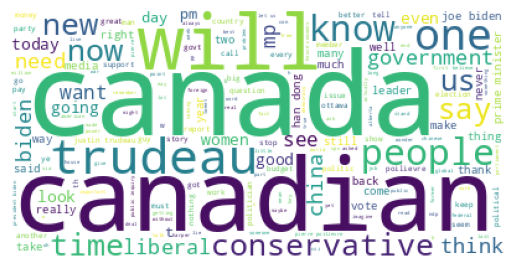

In [186]:
flatten_df = list_of_lists_to_list(df, 'Tokens')
display_word_cloud(flatten_df)

In [187]:
# Visualize the 15 most frequent words before lemmatizing
def visualize_20_most_frequent_words(flatten_data):
    words, counts = np.unique(flatten_data, return_counts=True)
    # Sort words and counts based on counts in descending order
    sorted_indices = np.argsort(counts)[::-1]   # index of descending count
    sorted_words = words[sorted_indices]
    sorted_counts = counts[sorted_indices]

    # # Print the 15 most frequent words
    # for word, count in zip(sorted_words[:20], sorted_counts[:20]):
    #     print(f'Word: {word}, count: {count}')

    # Visualize the 15 most frequent words
    plt.bar(sorted_words[:20], sorted_counts[:20])
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Histogram of the 20 most frequent words')
    plt.xticks(rotation=45, ha='right')
    plt.show()

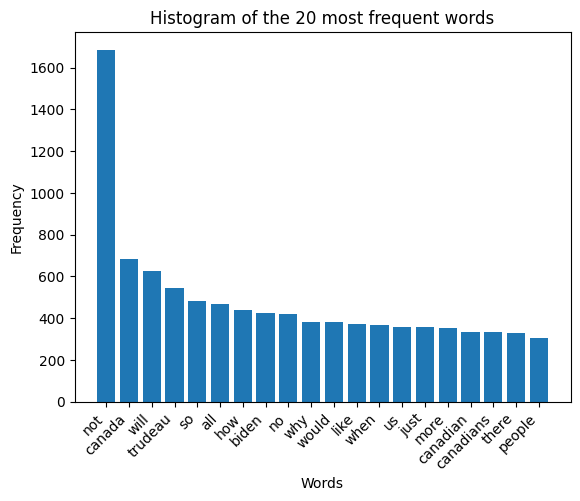

In [188]:
visualize_20_most_frequent_words(flatten_df)

## Text Pre-Processing 2

1. Lemmatize tokens
2. Create dictionary, corpus, and term document frequency list

In [189]:
# Lemmatize the tokens
lemmatize_tokens(df)

# # Convert the list of lists of strings (list of messages) to array of strings
# df = list_of_lists_to_list(df, 'lemmatized_tokens')

In [190]:
from sklearn.model_selection import train_test_split
# Split the data into training (60%), validation (20%), and test (20%) sets

# Splitting the data into training (60%) and temporary (40%) sets, setting the seed to ensure reproducibility
X_train, X_temp = train_test_split(df['lemmatized_tokens'], train_size=0.6, random_state=70)

# Splitting the temporary set into the validation (50% of the temporary data) and test (50% of the temporary data) sets
X_validate, X_test = train_test_split(X_temp, test_size=0.5, random_state=70)

In [191]:
import gensim.corpora as corpora

# Create dictionary
id2word = corpora.Dictionary(X_validate)

# Create Corpus
texts = X_validate

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [192]:
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


## Latent Dirichlet Allocation (LDA)

1. Tuning hyperparameters (search for the best number of topics): use validation data set
2. LDA setup (using training set)
3. Visualizing topics (pyLDAvis)

In [269]:
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

def calculate_coherence_score(LDA_model, data):
    coherence_model_LDA = CoherenceModel(model=LDA_model, texts=data, dictionary=id2word, coherence='c_v')
    return coherence_model_LDA.get_coherence()

In [268]:
# Tuning hyperparameters (search for the best number of topics)
# We're going to use default value for alpha and beta

best_coherence_score = -1
best_num_topics = -1

for num_topics in range(5, 15):
    LDA_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=70,
        per_word_topics=True
    )
    # Compute coherence score
    coherence_score = calculate_coherence_score(LDA_model, X_validate)
    print(coherence_score)
    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_num_topics = num_topics

print(f'Best topic: {best_num_topics} with coherence score {best_coherence_score} validated with X_validate')

0.23845270692595913


0.28372419463014736


0.2787314717641628


0.3272067279990291


0.36030825033530567


0.3424796882762411


KeyboardInterrupt: 

In [194]:
# We have computed the optimal number of topics to be included
# Now, we can setup our LDA model

# Create dictionary
id2word = corpora.Dictionary(X_train)

# Create Corpus
texts = X_train

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

LDA_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=best_num_topics,
    chunksize=1000,
    passes=10,
    random_state=70,
    per_word_topics=True
)

print(f'Coherence score for training data = {calculate_coherence_score(LDA_model, X_train)}')

Coherence score = 0.3918785724385332


In [195]:
def get_lda_topics(model, num_topics, top_n_words):
    word_dict = {}
    for i in range(num_topics):
        # Get the top words for the current topic using model.show_topic
        top_words = [word for word, _ in model.show_topic(i, topn=top_n_words)]
        # Create a dictionary entry for the topic with its top words
        word_dict['Topic #{:02d}'.format(i+1)] = top_words

    # Convert the dictionary to a DataFrame for easier visualization
    topics_df = pd.DataFrame(word_dict)
    return topics_df

get_lda_topics(LDA_model, best_num_topics,10)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10,Topic #11,Topic #12,Topic #13,Topic #14
0,biden,how,u,tax,not,not,house,very,day,not,know,biden,minister,canada
1,ottawa,dong,canada,canadian,michael,would,care,tweet,national,trudeau,there,not,prime,not
2,conservative,not,budget,interference,alberta,no,room,oh,border,see,most,poilievre,support,than
3,week,han,let,election,remember,just,account,first,show,when,here,joe,great,more
4,president,much,read,government,two,woman,common,hey,war,will,federal,leader,meeting,canadian
5,parliament,so,policy,chinese,point,like,b,email,country,canada,no,get,not,no
6,last,getting,good,public,part,one,night,sure,illegal,make,real,pierre,today,now
7,everyone,know,family,will,exactly,want,making,money,live,justin,thing,president,act,one
8,stand,global,need,foreign,important,party,6000,inflation,guess,would,canadian,canada,asked,h
9,canadian,ccp,big,canada,govt,there,health,must,security,so,2,speech,hard,any


In [196]:
LDA_model.print_topics()

[(0,
  '0.021*"biden" + 0.017*"ottawa" + 0.017*"conservative" + 0.016*"week" + 0.014*"president" + 0.013*"parliament" + 0.012*"last" + 0.012*"everyone" + 0.011*"stand" + 0.011*"canadian"'),
 (1,
  '0.027*"how" + 0.024*"dong" + 0.021*"not" + 0.018*"han" + 0.016*"much" + 0.016*"so" + 0.015*"getting" + 0.013*"know" + 0.013*"global" + 0.012*"ccp"'),
 (2,
  '0.026*"u" + 0.020*"canada" + 0.016*"budget" + 0.014*"let" + 0.013*"read" + 0.013*"policy" + 0.012*"good" + 0.012*"family" + 0.011*"need" + 0.010*"big"'),
 (3,
  '0.023*"tax" + 0.022*"canadian" + 0.019*"interference" + 0.015*"election" + 0.014*"government" + 0.013*"chinese" + 0.013*"public" + 0.012*"will" + 0.012*"foreign" + 0.012*"canada"'),
 (4,
  '0.025*"not" + 0.020*"michael" + 0.020*"alberta" + 0.019*"remember" + 0.018*"two" + 0.018*"point" + 0.014*"part" + 0.013*"exactly" + 0.011*"important" + 0.011*"govt"'),
 (5,
  '0.063*"not" + 0.031*"would" + 0.030*"no" + 0.028*"just" + 0.026*"woman" + 0.019*"like" + 0.015*"one" + 0.014*"want" 

In [270]:
print(f'Coherence score for test data = {calculate_coherence_score(LDA_model, X_test)}')

Coherence score for test data = 0.3625510871108707


In [197]:
doc_lda = LDA_model[corpus]

In [211]:
for i in range(len(doc_lda[0])):
    print(doc_lda[0][i])
print(len(doc_lda))

[(5, 0.45242283), (7, 0.45226705)]
[(0, [7]), (1, [7]), (2, [7]), (3, [5]), (4, [5]), (5, [5]), (6, [7]), (7, [5])]
[(0, [(7, 0.99934113)]), (1, [(7, 0.99934185)]), (2, [(7, 0.99962264)]), (3, [(5, 0.99736935)]), (4, [(5, 0.99998003)]), (5, [(5, 0.99996847)]), (6, [(7, 0.9950226)]), (7, [(5, 0.9999907)])]
6000


In [263]:
test_corpus = [id2word.doc2bow(text) for text in X_test]
doc_lda_test = LDA_model[test_corpus]
for topic in doc_lda_test[]:
    print(topic)
print(X_test[9200])
print(len(doc_lda_test))

IndexError: list index out of range

In [262]:
# X_test.to_csv('filename.csv', index=False)
X_test[9200]

['any',
 'public',
 'event',
 'planned',
 'two',
 'great',
 'leader',
 'biden',
 'justin']

In [266]:
one_corpus = [id2word.doc2bow(X_test[2343])]
doc_lda_one_test = LDA_model[one_corpus]
for topic in doc_lda_one_test:
    print(topic)
print(X_test[2343])

([(0, 0.010205641), (1, 0.010205761), (2, 0.3035277), (3, 0.010205641), (4, 0.010205641), (5, 0.2324412), (6, 0.010205641), (7, 0.010205655), (8, 0.010205641), (9, 0.19964494), (10, 0.01020565), (11, 0.010205733), (12, 0.16232948), (13, 0.010205658)], [(15, [2]), (70, [5, 9, 12, 2]), (324, [2]), (499, [9]), (726, [12]), (942, [5])], [(15, [(2, 0.99993825)]), (70, [(2, 0.05000646), (5, 0.5605331), (9, 0.32474723), (12, 0.06468172)]), (324, [(2, 0.99996245)]), (499, [(9, 0.9991903)]), (726, [(12, 0.9999265)]), (942, [(5, 0.99697316)])])
['how', 'pierre', 'justify', 'reckless', 'policy', 'going', 'support', 'mck']


In [238]:
df['lemmatized_tokens'][1024]

KeyError: 'lemmatized_tokens'

In [220]:
# Assuming you have preprocessed unseen data and created a corpus named 'unseen_corpus'
unseen_corpus = [['biden', 'trump', 'obama'], ['china', 'russia', 'us']]

# Convert the unseen corpus into bag-of-words representation
unseen_corpus_bow = [id2word.doc2bow(doc) for doc in unseen_corpus]

# Apply the trained LDA model to infer topic distributions for the unseen data
doc_lda_unseen = LDA_model[unseen_corpus_bow]

# Print the inferred topic distributions for each document in the unseen data
for doc in doc_lda_unseen:
    print(doc)

([(0, 0.4967501), (1, 0.01786762), (2, 0.01786762), (3, 0.017867643), (4, 0.01786762), (5, 0.01786762), (6, 0.01786762), (7, 0.01786762), (8, 0.01786762), (9, 0.28883833), (10, 0.01786762), (11, 0.017867768), (12, 0.01786762), (13, 0.01786762)], [(182, [0, 9]), (755, [9]), (2515, [0])], [(182, [(0, 0.9146723), (9, 0.085314594)]), (755, [(9, 0.9976988)]), (2515, [(0, 0.99996287)])])
([(0, 0.023806203), (1, 0.023806203), (2, 0.309981), (3, 0.023806315), (4, 0.023806307), (5, 0.02380634), (6, 0.023806203), (7, 0.023806203), (8, 0.023806356), (9, 0.023806255), (10, 0.023806203), (11, 0.40434387), (12, 0.023806233), (13, 0.023806293)], [(282, [2, 11]), (793, [11]), (8573, [])], [(282, [(2, 0.86050373), (11, 0.13943589)]), (793, [(11, 0.9999324)]), (8573, [])])


## Performance Evaluation

1. Eyeball
2. Weird technique

## Playground

In [199]:
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

def compute_relevance(word, sentence):
    # Process the sentence
    doc = nlp(sentence)
    return doc.similarity(nlp(word))
    # Compute relevance score for each token in the sentence
    # relevance_scores = []
    # for token in doc:
    #     relevance_score = token.similarity(nlp(word))
    #     relevance_scores.append(relevance_score)

    # # Calculate the average relevance score
    # average_relevance_score = sum(relevance_scores) / len(relevance_scores)

    # return average_relevance_score

sentence = "Okay. Hello, this is X insurance calling regarding a liability decision as well as to verify if there were any injuries in your insurance vehicle. And to confirm if the policy is active on the date of loss for the claim number XXXXXXXX. The claim number is XXXXXXXX. The adjuster could be reached at XXX XXX XXXX. Thank you. And have a nice day"
word = "Other insurance companies"
relevance_score = compute_relevance(word, sentence)
print(relevance_score)

0.2907108899342669


<ipython-input-199-f78fc5be58c9>:9: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  return doc.similarity(nlp(word))


# Back-up

In [200]:
# bearer_token="AAAAAAAAAAAAAAAAAAAAABjFsgEAAAAAlpTaLAR1wJ2sut2HNk8oY2r9u28%3DRWpfy37hyg15PEYEQJAQwhjS9S3RasSkc1WV35KH1FhBPfAgjF"


# import tweepy as tw

# client = tw.Client(bearer_token=bearer_token)


# # ONLY RUN THIS CELL ONCE IN LAB SO AVOID GOING OVER THE RATE LIMIT FOR THIS ACCOUNT!

# #Collect tweets (here, I get only 20)
# search_words = '#toronto'

# response = client.search_recent_tweets(search_words, max_results=100)
# tweets = response.data


# print(f'Number of tweets: {len(tweets)}')

# # The result is an iterable
# for tweet in tweets:
#   print(tweet.text)

# # Could also use a list comprehension


# tweet_list = [tweet.text for tweet in tweets]
# tweet_text = pd.DataFrame(tweet_list, columns = ['tweet'])

# print(tweet_text.head(5))


# # Extract handles
# handle_regex = '@[A-Za-z|0-9]+'

# tweet_text['handles'] = tweet_text['tweet'].str.findall(handle_regex)
# print(tweet_text.head(10))


# # Define the file path to save the DataFrame
# file_path = 'twitter_data.txt'

# # Write the DataFrame to a text file
# tweet_text.to_csv(file_path, sep='\t', index=False)

# print(f"DataFrame has been successfully written to '{file_path}'.")

In [201]:
# !wget "https://raw.githubusercontent.com/JanisJ2/jsc270-a4/main/tweets.csv"
# # Read the data form CSV file
# df = pd.read_csv('tweets.csv', index_col = 0)

--2024-03-31 21:39:03--  https://raw.githubusercontent.com/JanisJ2/jsc270-a4/main/tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1912231 (1.8M) [text/plain]
Saving to: ‘tweets.csv.4’

tweets.csv.4        100%[===================>]   1.82M  --.-KB/s    in 0.09s   

2024-03-31 21:39:03 (21.2 MB/s) - ‘tweets.csv.4’ saved [1912231/1912231]



In [202]:
# # rename the "tweet_text" column as "Messages"
# df = df.rename(columns={'tweet_text': 'Message'})

# # select only the column needed (in this case, we only need 'Messages')
# df = df[['Message']]

# df

,Message
0,The priority for the city should be on providi...
1,"Like it or not, this kind of clip is the sort ..."
2,On a scale of moderately conservative (1) to r...
3,Keep up with the latest politics with The Dail...
4,So much resemblance to NAZI Germany leading up...
...,...
9995,🇨🇦 and 🇺🇸 are working together 🤝\n\nThe Canada...
9996,Harper throws the #Poilievre sh1theads over th...
9997,@theJagmeetSingh Good. I called my @liberal_pa...
9998,@Theseaforge @theJagmeetSingh This motion incl...


In [203]:
# # Visualizing topics
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import os
# import copy

# # Visualize the topics
# pyLDAvis.enable_notebook()
# LDAvis_data_filepath = os.path.join('visualizations', 'LDAvis_prepared_'+str(10)+'.pkl')  # Adjust the path as needed
# # Check if the visualization data file exists
# if not os.path.exists(LDAvis_data_filepath):
#     # Prepare the visualization data
#     LDAvis_prepared = pyLDAvis.gensim.prepare(LDA_model, corpus, id2word)

#     # Exclude unpicklable elements from the LDAvis_prepared object
#     LDAvis_prepared_copy = copy.deepcopy(LDAvis_prepared)
#     LDAvis_prepared_copy.topic_info = None  # Exclude topic_info, which may contain unpicklable elements

#     # Save the modified visualization data to a file
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared_copy, f)
# else:
#     # Load the pre-prepared pyLDAvis data from disk
#     with open(LDAvis_data_filepath, 'rb') as f:
#         LDAvis_prepared = pickle.load(f)

# # Display the visualization
# pyLDAvis.display(LDAvis_prepared)


ModuleNotFoundError: No module named 'pyLDAvis'